# BLE Proximity Experiment - Random Forest Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [40]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Initialize Dataset
Initialization of the data from the file

In [41]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
#distance_proximity_experiments were made with purple beacon
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
456,0.0,4.0,-83,-84.250000,3-4 meters,4.0
457,0.0,4.0,-86,-84.600000,3-4 meters,4.0
458,0.0,4.0,-87,-85.000000,3-4 meters,4.0
459,0.0,4.0,-86,-85.142857,3-4 meters,4.0


(461, 6)

### File Overall Description
Usage of describe pandas function on the dataset

In [4]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,461.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
coordinate_Y,461.0,1.973970,1.274489,0.0,1.0,2.00,3.0,4.0
rssi_Value,461.0,-78.206074,9.461756,-94.0,-85.0,-81.00,-75.0,-50.0
rolling_mean_rssi,461.0,-78.065939,9.240107,-91.0,-84.0,-81.25,-76.0,-50.0
distance,461.0,1.973970,1.274489,0.0,1.0,2.00,3.0,4.0


### Scanned Zones
Graphical display of the zones scanned in the experiment

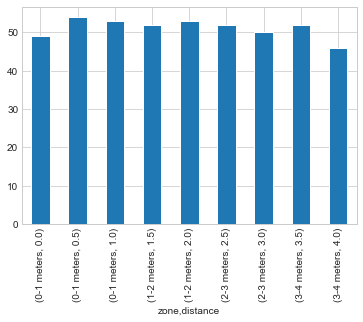

In [5]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

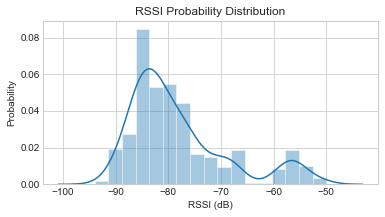

In [6]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

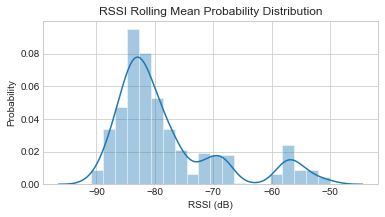

In [7]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

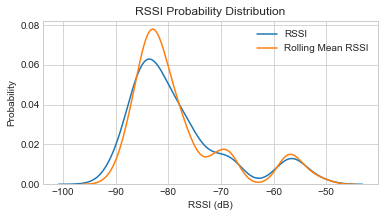

In [8]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Initialize Training Data
Training Data intialization for predictions purposes

In [9]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
train_Y = pd.DataFrame(dataset['zone']).values.reshape(-1,1)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
default_groups = dataset['zone'].map(str)
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-69.205128,-69.220368
1-2 meters,-79.952381,-79.981444
2-3 meters,-84.107843,-84.048751
3-4 meters,-84.520408,-83.867310


### Initialize Hyperparameters for tunning

In [10]:
#Preprocessing options
scaler = [StandardScaler(),MaxAbsScaler(),MinMaxScaler(),None]
# Number of trees in random forest
initial_linespace = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] 
n_estimators = [10,100] + initial_linespace
# Criterion to consider at every split
criterion_metric = ['gini','entropy']
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__criterion': criterion_metric,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}
print(random_grid)

{'rf__n_estimators': [10, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'rf__criterion': ['gini', 'entropy'], 'rf__max_features': ['auto', 'sqrt', 'log2'], 'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'rf__min_samples_split': [2, 5, 10], 'rf__min_samples_leaf': [1, 2, 4], 'rf__bootstrap': [True, False]}


### Plot Training Data
Graphical Display of the observations in the dataset

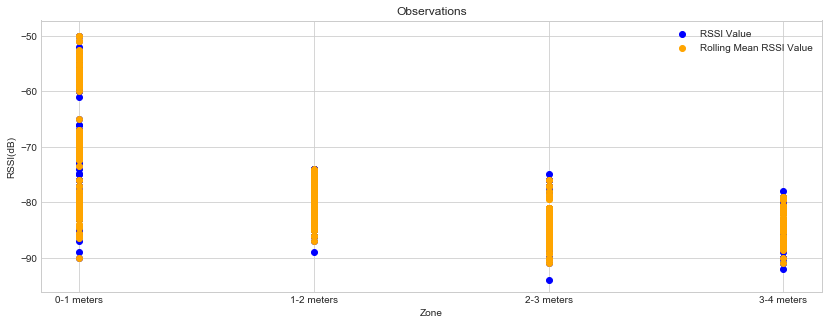

In [11]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [12]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

### Random Forest Classifier Experiments
Experiments with RF algorithm

In [13]:
def compute_RF_Classification(flag=0,colors=None,
                              trainX_data = None,fold=None, trainY_data = None,
                              testX_data = None,testY_data = None, 
                              scaler = None,cross_validation = None,
                              n_estimators_parameter = 100, criterion_parameter = 'gini',
                              max_depth_parameter = None,min_samples_split_parameter = 2,
                              min_samples_leaf_parameter = 1,max_features_parameter = 'auto',
                              bootstrap_parameter = True, random_state_parameter = 6):
    random_forest_estimator = RandomForestClassifier(n_estimators=n_estimators_parameter,criterion=criterion_parameter,
                                                    max_features=max_features_parameter,max_depth=max_depth_parameter,
                                                    min_samples_leaf=min_samples_leaf_parameter,min_samples_split=min_samples_split_parameter,
                                                    bootstrap=bootstrap_parameter,random_state=random_state_parameter)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,random_forest_estimator)
    else:
        main_estimator = random_forest_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        main_estimator.fit(testX_data,testY_data)
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        plt.figure(figsize=(12,6))
        plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
        plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
        if colors is not None:
            plt.plot(predict_test, testX_data,'s',color=colors,label='RF Classification' + ' CV : ' +str(fold))
        else:
            plt.plot(predict_test, testX_data,'s',color='red',label='RF Classification')
        # Show and place the legent
        plt.legend(loc='upper right')
        plt.show()
    if flag == 2:
        print("Feature Selection Computation")
        display(random_forest_estimator.feature_importances_)
        feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=trainX_data.columns).sort_values(ascending=False)
        display(feature_imp)
        # Creating a bar plot
        sns.barplot(x=feature_imp, y=feature_imp.index)
        # Add labels to your graph
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title("Visualizing Important Features")
        plt.show()
    display('Number of Classes Predicted: ' + str(random_forest_estimator.n_classes_))
    display('Number of Features Used: ' + str(random_forest_estimator.n_features_))
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

#### Feature Selection & OverFitting Scenario

Feature Selection Computation


array([0.36868816, 0.63131184])

rolling_mean_rssi    0.631312
rssi_Value           0.368688
dtype: float64

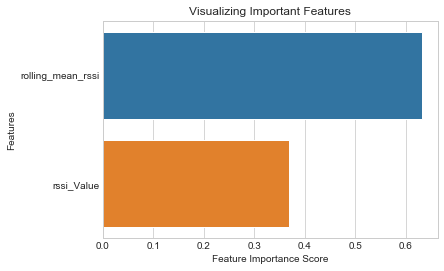

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score
0,0.149675,0.149675,0.386878,0.844236,0.850325,0.844383


In [14]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_RF_Classification(flag=2,trainX_data=combination_features_X,trainY_data=train_Y.ravel(),
                                   testX_data=combination_features_X,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 1st Experiment - Check Overfitting scenario (Without Testing Data) Using RSSI
Use Random Forest to check the results on the training data alone

Confusion Matrix:
[[101  32   6  17]
 [  0  72  12  21]
 [  0  26  50  26]
 [  0  15  35  48]]


,precision,recall,f1-score,support
0-1 meters,1.000000,0.647436,0.785992,156.000000
1-2 meters,0.496552,0.685714,0.576000,105.000000
2-3 meters,0.485437,0.490196,0.487805,102.000000
3-4 meters,0.428571,0.489796,0.457143,98.000000
accuracy,0.587852,0.587852,0.587852,0.587852
macro avg,0.602640,0.578286,0.576735,461.000000
weighted avg,0.650005,0.587852,0.602280,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,3-4 meters
457,3-4 meters,2-3 meters
458,3-4 meters,3-4 meters
459,3-4 meters,2-3 meters


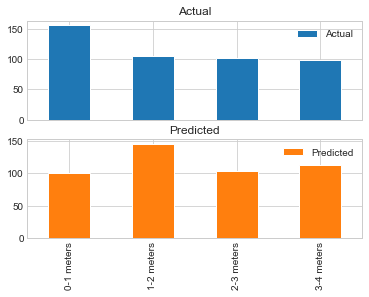

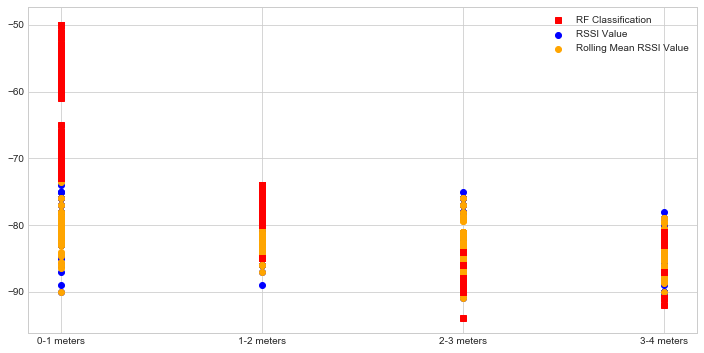

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

,mae,mse,rmse,precision,accuracy,f1-score
0,0.412148,0.412148,0.641987,0.607294,0.587852,0.581972


In [15]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_RF_Classification(flag=1,trainX_data=train_X_rssi,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rssi,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 2nd Experiment - Check Overfitting scenario (Without Testing Data) Using Rolling Mean
Use Random Forest to check the results on the training data alone

Confusion Matrix:
[[114  13  14  15]
 [  1  66  17  21]
 [  2   8  69  23]
 [  2   6  23  67]]


,precision,recall,f1-score,support
0-1 meters,0.957983,0.730769,0.829091,156.000000
1-2 meters,0.709677,0.628571,0.666667,105.000000
2-3 meters,0.560976,0.676471,0.613333,102.000000
3-4 meters,0.531746,0.683673,0.598214,98.000000
accuracy,0.685466,0.685466,0.685466,0.685466
macro avg,0.690096,0.679871,0.676826,461.000000
weighted avg,0.722976,0.685466,0.695278,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,3-4 meters
458,3-4 meters,3-4 meters
459,3-4 meters,3-4 meters


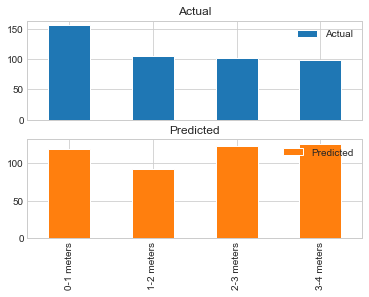

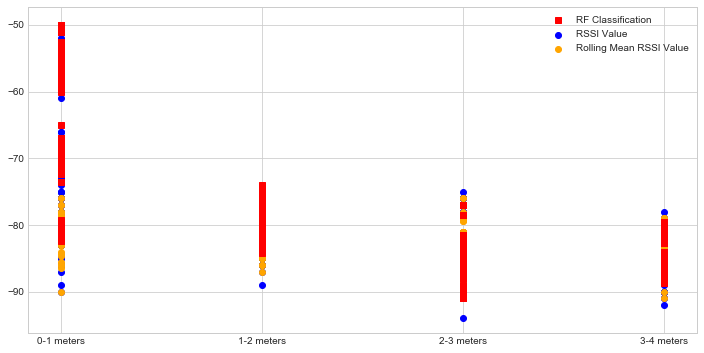

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

,mae,mse,rmse,precision,accuracy,f1-score
0,0.314534,0.314534,0.560833,0.694132,0.685466,0.680697


In [16]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_RF_Classification(flag=1,trainX_data=train_X_rolling_mean,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 3rd Experiment - Random Forest with StratifiedKFold (RSSI pure)
Experiment using cross validation approach of StratifiedKFold

Confusion Matrix:
[[102  26  12  16]
 [ 36  35  13  21]
 [ 14  16  47  25]
 [ 19  20  43  16]]


,precision,recall,f1-score,support
0-1 meters,0.596491,0.653846,0.623853,156.000000
1-2 meters,0.360825,0.333333,0.346535,105.000000
2-3 meters,0.408696,0.460784,0.433180,102.000000
3-4 meters,0.205128,0.163265,0.181818,98.000000
accuracy,0.433839,0.433839,0.433839,0.433839
macro avg,0.392785,0.402807,0.396346,461.000000
weighted avg,0.418067,0.433839,0.424533,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,3-4 meters
457,3-4 meters,2-3 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


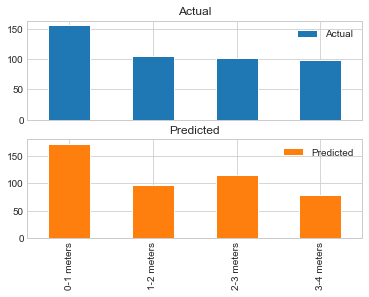

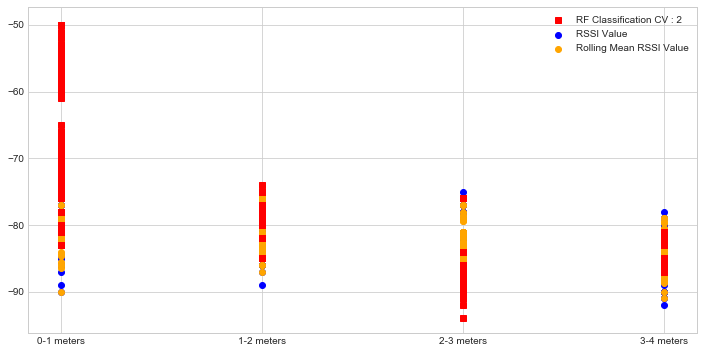

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

Confusion Matrix:
[[100  29  10  17]
 [ 25  40  13  27]
 [ 10  16  19  57]
 [ 15  13  42  28]]


,precision,recall,f1-score,support
0-1 meters,0.666667,0.641026,0.653595,156.00000
1-2 meters,0.408163,0.380952,0.394089,105.00000
2-3 meters,0.226190,0.186275,0.204301,102.00000
3-4 meters,0.217054,0.285714,0.246696,98.00000
accuracy,0.405640,0.405640,0.405640,0.40564
macro avg,0.379519,0.373492,0.374670,461.00000
weighted avg,0.414750,0.405640,0.408579,461.00000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,3-4 meters
457,3-4 meters,2-3 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


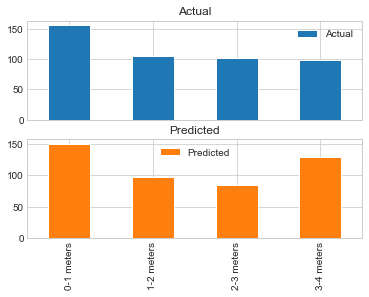

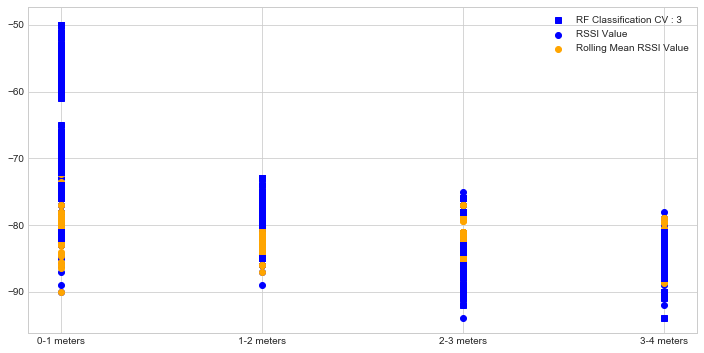

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

Confusion Matrix:
[[99 28  9 20]
 [15 50 11 29]
 [ 4 20 26 52]
 [ 1 28 43 26]]


,precision,recall,f1-score,support
0-1 meters,0.831933,0.634615,0.720000,156.000000
1-2 meters,0.396825,0.476190,0.432900,105.000000
2-3 meters,0.292135,0.254902,0.272251,102.000000
3-4 meters,0.204724,0.265306,0.231111,98.000000
accuracy,0.436009,0.436009,0.436009,0.436009
macro avg,0.431404,0.407753,0.414066,461.000000
weighted avg,0.480063,0.436009,0.451612,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,3-4 meters
457,3-4 meters,2-3 meters
458,3-4 meters,3-4 meters
459,3-4 meters,2-3 meters


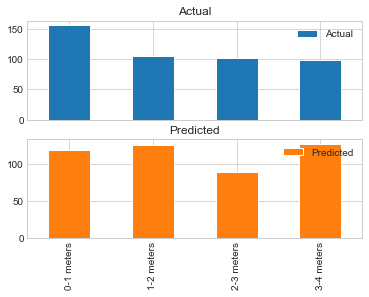

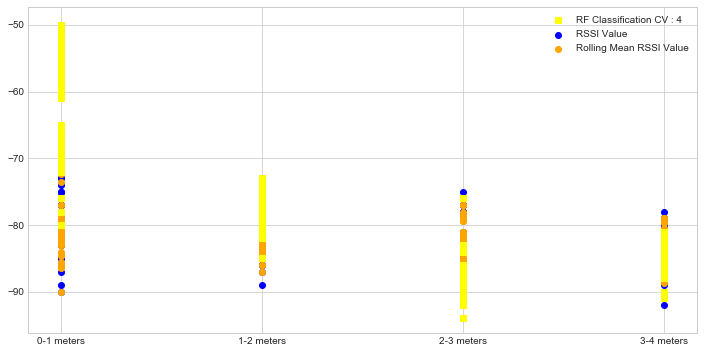

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

Confusion Matrix:
[[102  25  10  19]
 [  5  56  16  28]
 [  0  18  31  53]
 [  5  20  42  31]]


,precision,recall,f1-score,support
0-1 meters,0.910714,0.653846,0.761194,156.000000
1-2 meters,0.470588,0.533333,0.500000,105.000000
2-3 meters,0.313131,0.303922,0.308458,102.000000
3-4 meters,0.236641,0.316327,0.270742,98.000000
accuracy,0.477223,0.477223,0.477223,0.477223
macro avg,0.482769,0.451857,0.460099,461.000000
weighted avg,0.534953,0.477223,0.497271,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,3-4 meters
457,3-4 meters,2-3 meters
458,3-4 meters,3-4 meters
459,3-4 meters,2-3 meters


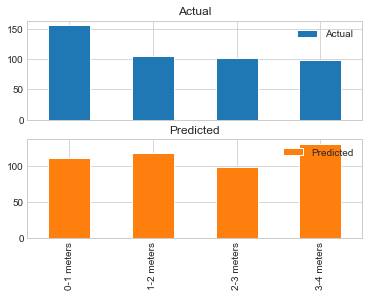

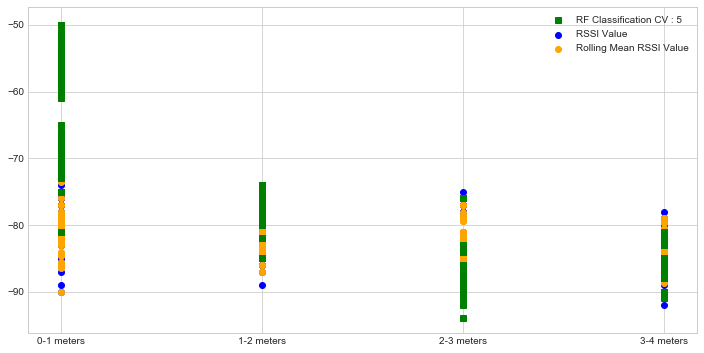

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

,mae,mse,rmse,precision,accuracy,f1-score,folds
3,0.522777,0.522777,0.723033,0.489431,0.477223,0.467855,5
2,0.563991,0.563991,0.750994,0.439013,0.436009,0.422564,4
0,0.566161,0.566161,0.752436,0.402262,0.433839,0.405729,2
1,0.594360,0.594360,0.770948,0.388283,0.405640,0.383939,3


Number of Folds:  5


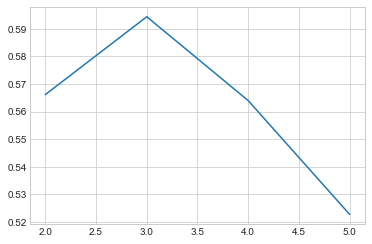

In [17]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    result = compute_RF_Classification(flag = 1,colors=colors[counter],fold=cv,testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 4th Experiment - Random Forest with StratifiedKFold (Rolling Mean)
Experiment using cross validation approach of StratifiedKFold

Confusion Matrix:
[[103  11  17  25]
 [ 35  24  24  22]
 [ 22  10  50  20]
 [ 35  11  39  13]]


,precision,recall,f1-score,support
0-1 meters,0.528205,0.660256,0.586895,156.000000
1-2 meters,0.428571,0.228571,0.298137,105.000000
2-3 meters,0.384615,0.490196,0.431034,102.000000
3-4 meters,0.162500,0.132653,0.146067,98.000000
accuracy,0.412148,0.412148,0.412148,0.412148
macro avg,0.375973,0.377919,0.365533,461.000000
weighted avg,0.395999,0.412148,0.392928,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,3-4 meters
458,3-4 meters,1-2 meters
459,3-4 meters,2-3 meters


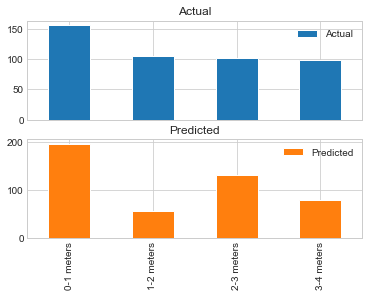

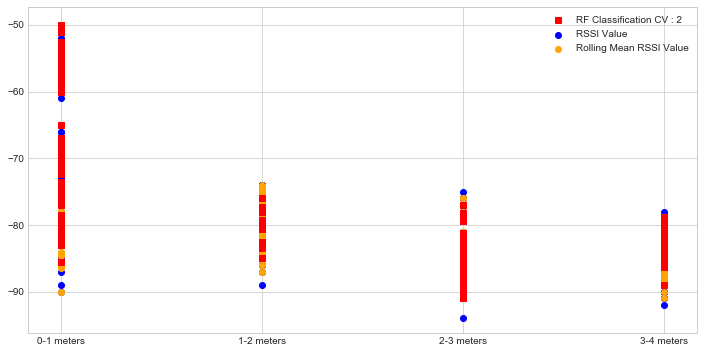

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

Confusion Matrix:
[[103  13  13  27]
 [ 32  23  21  29]
 [ 12  10  34  46]
 [ 14  12  33  39]]


,precision,recall,f1-score,support
0-1 meters,0.639752,0.660256,0.649842,156.00000
1-2 meters,0.396552,0.219048,0.282209,105.00000
2-3 meters,0.336634,0.333333,0.334975,102.00000
3-4 meters,0.276596,0.397959,0.326360,98.00000
accuracy,0.431670,0.431670,0.431670,0.43167
macro avg,0.412383,0.402649,0.398347,461.00000
weighted avg,0.440092,0.431670,0.427675,461.00000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,3-4 meters
457,3-4 meters,1-2 meters
458,3-4 meters,1-2 meters
459,3-4 meters,2-3 meters


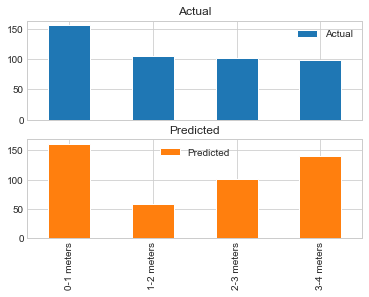

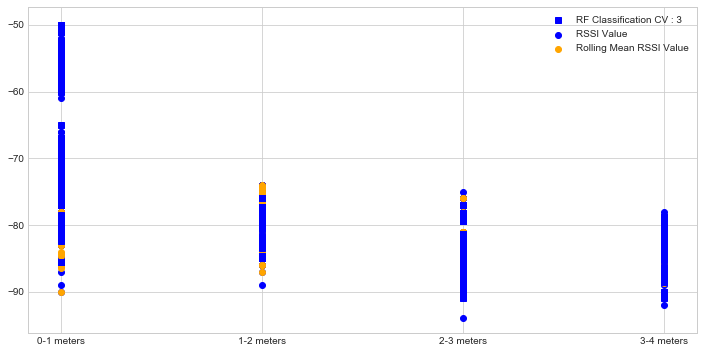

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

Confusion Matrix:
[[100  19  19  18]
 [ 11  44  27  23]
 [ 11  22  34  35]
 [ 21  17  40  20]]


,precision,recall,f1-score,support
0-1 meters,0.699301,0.641026,0.668896,156.000000
1-2 meters,0.431373,0.419048,0.425121,105.000000
2-3 meters,0.283333,0.333333,0.306306,102.000000
3-4 meters,0.208333,0.204082,0.206186,98.000000
accuracy,0.429501,0.429501,0.429501,0.429501
macro avg,0.405585,0.399372,0.401627,461.000000
weighted avg,0.441869,0.429501,0.434783,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,1-2 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


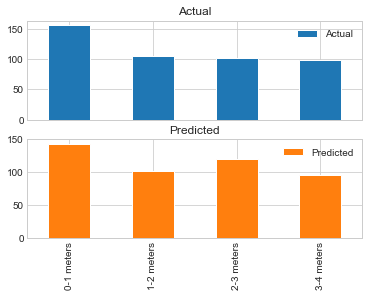

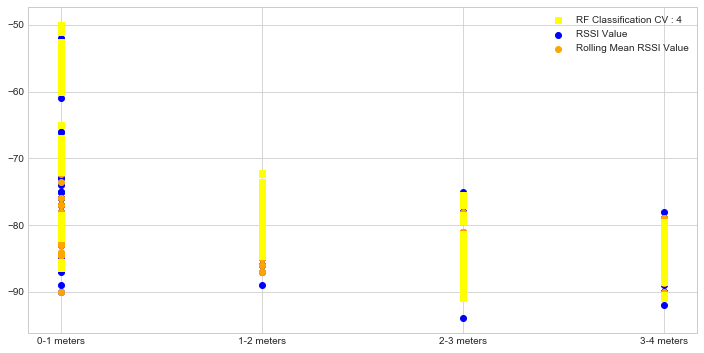

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

Confusion Matrix:
[[102  16  16  22]
 [ 15  45  22  23]
 [ 12  12  35  43]
 [ 19  10  46  23]]


,precision,recall,f1-score,support
0-1 meters,0.689189,0.653846,0.671053,156.000000
1-2 meters,0.542169,0.428571,0.478723,105.000000
2-3 meters,0.294118,0.343137,0.316742,102.000000
3-4 meters,0.207207,0.234694,0.220096,98.000000
accuracy,0.444685,0.444685,0.444685,0.444685
macro avg,0.433171,0.415062,0.421653,461.000000
weighted avg,0.465830,0.444685,0.452988,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,2-3 meters
457,3-4 meters,1-2 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


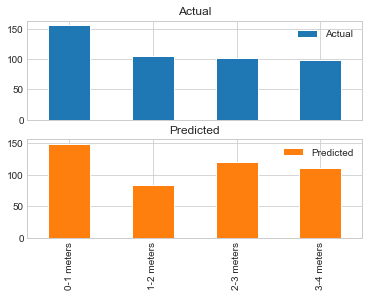

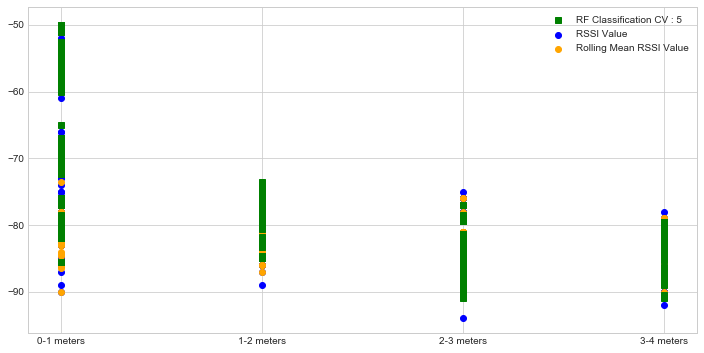

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

,mae,mse,rmse,precision,accuracy,f1-score,folds
3,0.555315,0.555315,0.745194,0.439481,0.444685,0.429420,5
1,0.568330,0.568330,0.753876,0.419097,0.431670,0.407297,3
2,0.570499,0.570499,0.755314,0.414185,0.429501,0.410346,4
0,0.587852,0.587852,0.766715,0.384002,0.412148,0.376106,2


Number of Folds:  5


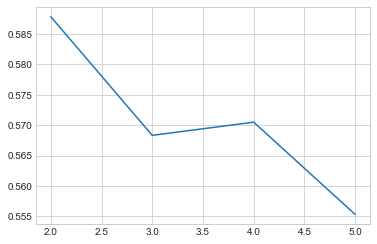

In [18]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    result = compute_RF_Classification(flag = 1,colors=colors[counter],fold=cv,testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Combination of Features - Stratified KFold Experiment

Confusion Matrix:
[[103  16  17  20]
 [ 38  25  15  27]
 [ 23  15  42  22]
 [ 25  21  38  14]]


,precision,recall,f1-score,support
0-1 meters,0.544974,0.660256,0.597101,156.000000
1-2 meters,0.324675,0.238095,0.274725,105.000000
2-3 meters,0.375000,0.411765,0.392523,102.000000
3-4 meters,0.168675,0.142857,0.154696,98.000000
accuracy,0.399132,0.399132,0.399132,0.399132
macro avg,0.353331,0.363243,0.354762,461.000000
weighted avg,0.377195,0.399132,0.384364,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,1-2 meters
457,3-4 meters,3-4 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


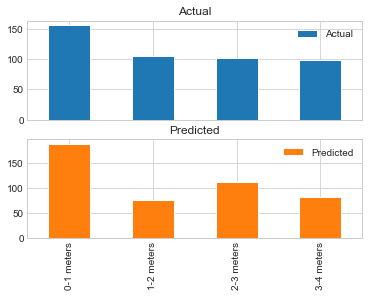

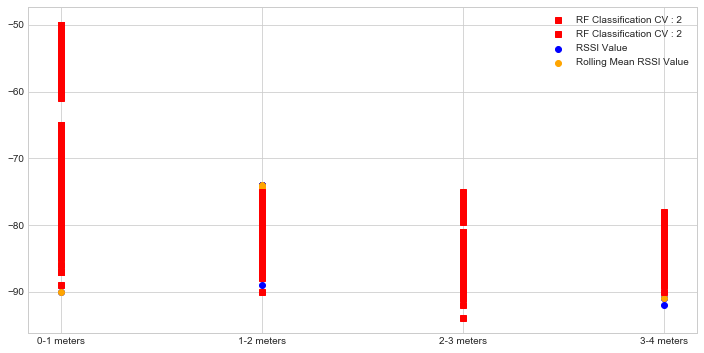

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

Confusion Matrix:
[[103  21  15  17]
 [ 42  26  18  19]
 [ 18  16  25  43]
 [ 12  16  38  32]]


,precision,recall,f1-score,support
0-1 meters,0.588571,0.660256,0.622356,156.000000
1-2 meters,0.329114,0.247619,0.282609,105.000000
2-3 meters,0.260417,0.245098,0.252525,102.000000
3-4 meters,0.288288,0.326531,0.306220,98.000000
accuracy,0.403471,0.403471,0.403471,0.403471
macro avg,0.366598,0.369876,0.365928,461.000000
weighted avg,0.393034,0.403471,0.395941,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,3-4 meters
457,3-4 meters,2-3 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


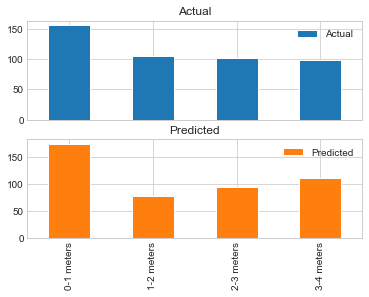

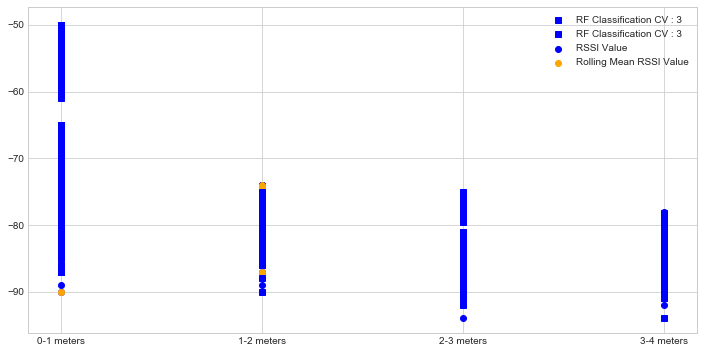

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

Confusion Matrix:
[[106  23  13  14]
 [ 19  45  18  23]
 [ 17  19  25  41]
 [ 11  16  42  29]]


,precision,recall,f1-score,support
0-1 meters,0.692810,0.679487,0.686084,156.000000
1-2 meters,0.436893,0.428571,0.432692,105.000000
2-3 meters,0.255102,0.245098,0.250000,102.000000
3-4 meters,0.271028,0.295918,0.282927,98.000000
accuracy,0.444685,0.444685,0.444685,0.444685
macro avg,0.413958,0.412269,0.412926,461.000000
weighted avg,0.448012,0.444685,0.446179,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,3-4 meters
457,3-4 meters,3-4 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


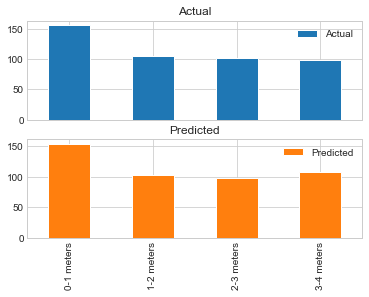

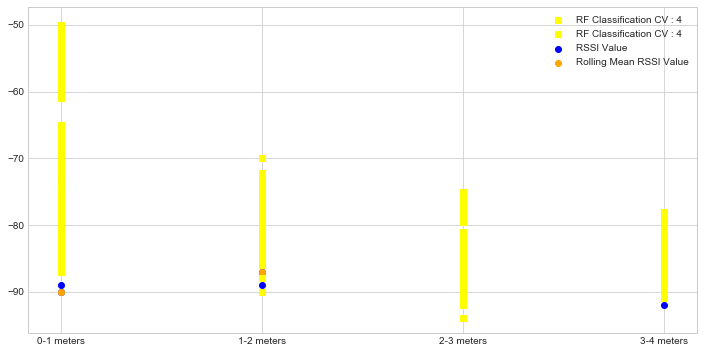

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

Confusion Matrix:
[[108  22  16  10]
 [ 23  47  17  18]
 [ 12  20  29  41]
 [  6   9  51  32]]


,precision,recall,f1-score,support
0-1 meters,0.724832,0.692308,0.708197,156.000000
1-2 meters,0.479592,0.447619,0.463054,105.000000
2-3 meters,0.256637,0.284314,0.269767,102.000000
3-4 meters,0.316832,0.326531,0.321608,98.000000
accuracy,0.468547,0.468547,0.468547,0.468547
macro avg,0.444473,0.437693,0.440657,461.000000
weighted avg,0.478650,0.468547,0.473174,461.000000


,Actual,Predicted
0,0-1 meters,0-1 meters
1,0-1 meters,0-1 meters
2,0-1 meters,0-1 meters
3,0-1 meters,0-1 meters
4,0-1 meters,0-1 meters
...,...,...
456,3-4 meters,3-4 meters
457,3-4 meters,2-3 meters
458,3-4 meters,2-3 meters
459,3-4 meters,2-3 meters


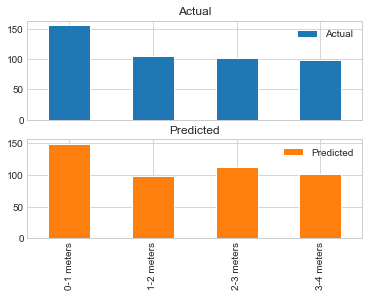

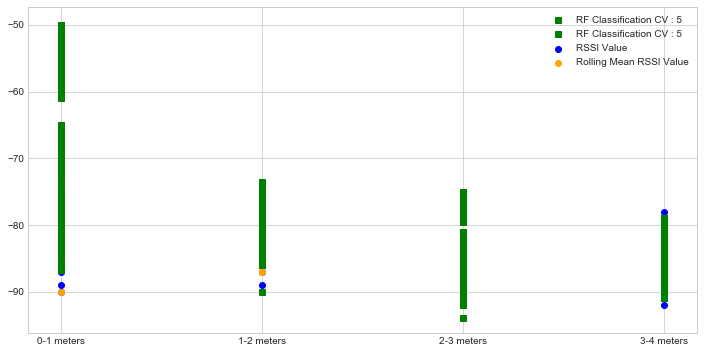

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,folds
3,0.531453,0.531453,0.729008,0.452795,0.468547,0.449286,5
2,0.555315,0.555315,0.745194,0.423213,0.444685,0.422213,4
1,0.596529,0.596529,0.772353,0.375642,0.403471,0.375579,3
0,0.600868,0.600868,0.775157,0.363283,0.399132,0.365329,2


Number of Folds:  5


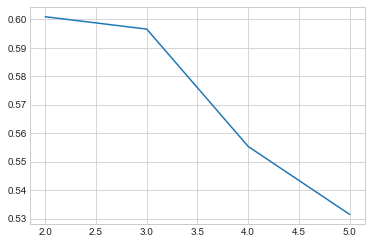

In [19]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,6)
colors = ['red','blue','yellow','green']
counter = 0
results = list()
for cv in cross_validation_list:
    result = compute_RF_Classification(flag = 1,colors=colors[counter],fold=cv,testX_data=combination_features_X,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 5th Experiment - Random Forest with HoldOut (RSSI pure)
Experiment using cross validation approach of HoldOut (Train test split)

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

,mae,mse,rmse,precision,accuracy,f1-score,test_size
7,0.466125,0.466125,0.682733,0.543358,0.533875,0.510258,0.8
2,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,0.3
6,0.489164,0.489164,0.699403,0.517036,0.510836,0.500385,0.7
3,0.497297,0.497297,0.705193,0.504997,0.502703,0.492138,0.4
8,0.498795,0.498795,0.706254,0.486802,0.501205,0.482184,0.9
5,0.494585,0.494585,0.703267,0.507561,0.505415,0.480766,0.6
4,0.502165,0.502165,0.708636,0.503261,0.497835,0.475025,0.5
1,0.526882,0.526882,0.725866,0.473719,0.473118,0.463914,0.2
0,0.531915,0.531915,0.729325,0.487044,0.468085,0.454583,0.1


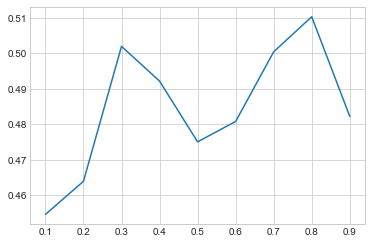

In [20]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rssi,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### 6th Experiment - Random Forest with HoldOut (Rolling Mean)
Experiment using cross validation approach of HoldOut (Train test split)

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

,mae,mse,rmse,precision,accuracy,f1-score,test_size
0,0.404255,0.404255,0.635811,0.603922,0.595745,0.588271,0.1
2,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,0.3
1,0.483871,0.483871,0.695608,0.532407,0.516129,0.510193,0.2
3,0.481081,0.481081,0.693600,0.521524,0.518919,0.507931,0.4
4,0.497835,0.497835,0.705575,0.511999,0.502165,0.493306,0.5
5,0.494585,0.494585,0.703267,0.498781,0.505415,0.490560,0.6
7,0.498645,0.498645,0.706148,0.493336,0.501355,0.485808,0.8
8,0.508434,0.508434,0.713045,0.473778,0.491566,0.469498,0.9
6,0.513932,0.513932,0.716890,0.471258,0.486068,0.468497,0.7


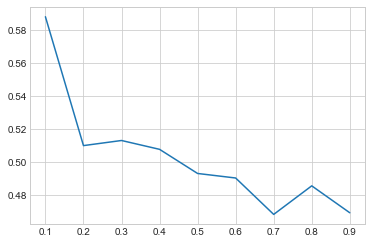

In [21]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rolling_mean,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### Combination of Features - HoldOut Experiment

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,test_size
0,0.425532,0.425532,0.652328,0.538188,0.574468,0.540353,0.1
2,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,0.3
1,0.451613,0.451613,0.672022,0.539919,0.548387,0.535114,0.2
6,0.461300,0.461300,0.679191,0.529561,0.538700,0.523780,0.7
5,0.465704,0.465704,0.682425,0.518736,0.534296,0.516632,0.6
4,0.476190,0.476190,0.690066,0.510804,0.523810,0.505507,0.5
3,0.470270,0.470270,0.685763,0.503327,0.529730,0.504344,0.4
8,0.484337,0.484337,0.695943,0.499910,0.515663,0.498930,0.9
7,0.474255,0.474255,0.688662,0.499825,0.525745,0.498127,0.8


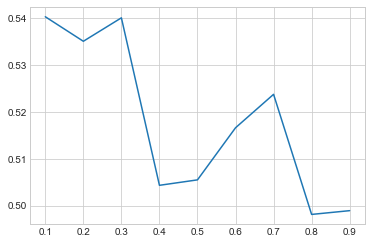

In [22]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(combination_features_X,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['test_size'],statistics['f1-score'])

#### 7th Experiment - Random Forest with LOGO (RSSI)
Experiment using cross validation approach of Leave One Group Out

In [23]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rssi,train_Y.ravel(),groups=default_groups)
loo = compute_RF_Classification(testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

,mae,mse,rmse,precision,accuracy,f1-score
0,1.0,1.0,1.0,0.0,0.0,0.0


#### 8th Experiment - Random Forest with LOGO (Rolling Mean)
Experiment using cross validation approach of Leave One Group Out

In [24]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rolling_mean,train_Y.ravel(),groups=default_groups)
loo = compute_RF_Classification(testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

,mae,mse,rmse,precision,accuracy,f1-score
0,1.0,1.0,1.0,0.0,0.0,0.0


#### Combination of Features - LOGO Experiment

In [25]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(combination_features_X,train_Y.ravel(),groups=default_groups)
loo = compute_RF_Classification(testX_data=combination_features_X,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score
0,1.0,1.0,1.0,0.0,0.0,0.0


#### 9th Experiment - Best cross-validation technique
Best parameters found using RF

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,method,type
7,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,HoldOut,Both
4,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,HoldOut,Rolling Mean RSSI
1,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,HoldOut,RSSI Only
2,0.522777,0.522777,0.723033,0.489431,0.477223,0.467855,Stratified K-Fold,RSSI Only
8,0.531453,0.531453,0.729008,0.452795,0.468547,0.449286,Stratified K-Fold,Both
5,0.555315,0.555315,0.745194,0.439481,0.444685,0.429420,Stratified K-Fold,Rolling Mean RSSI
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,RSSI Only
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Rolling Mean RSSI
6,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Both


Selected cross validation method:  HoldOut


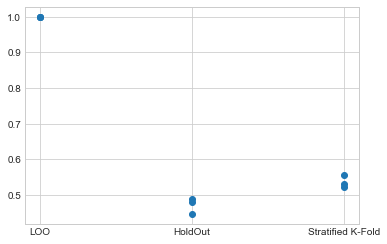

In [26]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
    holdout = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
    loo = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skfold = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold)
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### 10th Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,preprocessing,preprocessingFunc,type
8,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Both
9,0.453237,0.453237,0.673229,0.538390,0.546763,0.532055,MaxAbsScaler,MaxAbsScaler(copy=True),Both
10,0.453237,0.453237,0.673229,0.534922,0.546763,0.531534,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Both
11,0.453237,0.453237,0.673229,0.538390,0.546763,0.532055,None,None,Both
4,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
0,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
1,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,MaxAbsScaler,MaxAbsScaler(copy=True),RSSI Only
2,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only
3,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,None,None,RSSI Only
5,0.489209,0.489209,0.699435,0.524861,0.510791,0.505764,MaxAbsScaler,MaxAbsScaler(copy=True),Rolling Mean RSSI


Selected Preprocessing:  StandardScaler


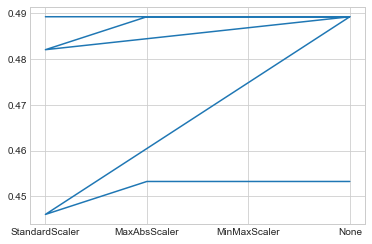

In [27]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### 11th Experiment - Running the RF function with the different number of decision trees

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,n_estimator,type
28,0.424460,0.424460,0.651506,0.571019,0.575540,0.564743,600,Both
26,0.431655,0.431655,0.657004,0.555492,0.568345,0.553508,200,Both
27,0.431655,0.431655,0.657004,0.561253,0.568345,0.556453,400,Both
32,0.438849,0.438849,0.662457,0.553775,0.561151,0.548341,1400,Both
31,0.438849,0.438849,0.662457,0.556324,0.561151,0.549129,1200,Both
30,0.438849,0.438849,0.662457,0.556324,0.561151,0.549129,1000,Both
29,0.438849,0.438849,0.662457,0.556324,0.561151,0.549129,800,Both
25,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,100,Both
35,0.446043,0.446043,0.667865,0.546371,0.553957,0.540738,2000,Both
33,0.446043,0.446043,0.667865,0.546371,0.553957,0.540738,1600,Both


Selected Estimator Size:  600


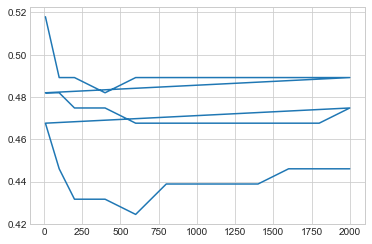

In [28]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','n_estimator','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for n in n_estimators:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                n_estimators_parameter=n)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 n_estimators_parameter=n)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), n_estimators_parameter=n)
        result.append(n)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['n_estimator'],statistics['mae'])
selected_estimator_size = statistics.sort_values(by=['mae'])['n_estimator'].head(1).values[0]
print("Selected Estimator Size: ",selected_estimator_size)

#### 12th Experiment - Running the RF function with the different criterias

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,criterion,type
5,0.431655,0.431655,0.657004,0.560203,0.568345,0.553888,entropy,Both
4,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,gini,Both
2,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,gini,Rolling Mean RSSI
3,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,entropy,Rolling Mean RSSI
0,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,gini,RSSI Only
1,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,entropy,RSSI Only


Selected Criterion:  entropy


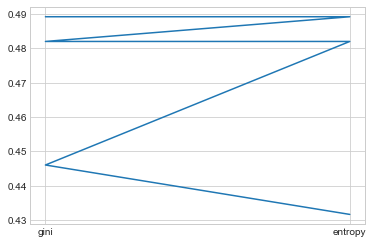

In [29]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','criterion','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for metric in criterion_metric:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                criterion_parameter=metric)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 criterion_parameter=metric)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), criterion_parameter=metric)
        result.append(metric)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['criterion'],statistics['mae'])
selected_criterion = statistics.sort_values(by=['mae'])['criterion'].head(1).values[0]
print("Selected Criterion: ",selected_criterion)

#### 13th Experiment - Running the RF function with the different max_features 

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,max_feature,type
6,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,auto,Both
7,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,sqrt,Both
8,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,log2,Both
3,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,auto,Rolling Mean RSSI
4,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,sqrt,Rolling Mean RSSI
5,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,log2,Rolling Mean RSSI
0,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,auto,RSSI Only
1,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,sqrt,RSSI Only
2,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,log2,RSSI Only


Selected max_feature:  auto


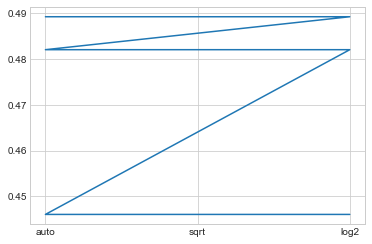

In [30]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','max_feature','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for max_feature in max_features:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                max_features_parameter=max_feature)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 max_features_parameter=max_feature)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), max_features_parameter=max_feature)
        result.append(max_feature)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['max_feature'],statistics['mae'])
selected_max_feature = statistics.sort_values(by=['mae'])['max_feature'].head(1).values[0]
print("Selected max_feature: ",selected_max_feature)

#### 14th Experiment - Running the RF function with the different max_depth metric

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,max_depth,type
24,0.417266,0.417266,0.645961,0.579883,0.582734,0.572885,10.0,Both
35,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,NaN,Both
25,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,20.0,Both
27,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,40.0,Both
28,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,50.0,Both
26,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,30.0,Both
30,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,70.0,Both
31,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,80.0,Both
32,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,90.0,Both
33,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,100.0,Both


Selected max_depth:  10.0


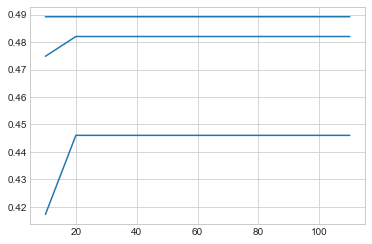

In [31]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','max_depth','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for depth in max_depth:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                max_depth_parameter=depth)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 max_depth_parameter=depth)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), max_depth_parameter=depth)
        result.append(depth)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['max_depth'],statistics['mae'])
selected_max_depth = statistics.sort_values(by=['mae'])['max_depth'].head(1).values[0]
print("Selected max_depth: ",selected_max_depth)

#### 15th Experiment: Running the RF function with the different min_samples_split metric

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,min_samples_split,type
6,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,2,Both
8,0.446043,0.446043,0.667865,0.549842,0.553957,0.543056,10,Both
7,0.460432,0.460432,0.678551,0.527648,0.539568,0.525771,5,Both
4,0.467626,0.467626,0.683832,0.552067,0.532374,0.528948,5,Rolling Mean RSSI
5,0.474820,0.474820,0.689072,0.544883,0.525180,0.520511,10,Rolling Mean RSSI
3,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,2,Rolling Mean RSSI
0,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,2,RSSI Only
1,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,5,RSSI Only
2,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,10,RSSI Only


Selected min_samples_split:  2


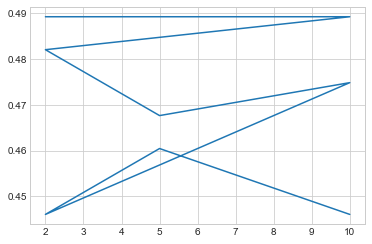

In [32]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','min_samples_split','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for s in min_samples_split:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                min_samples_split_parameter=s)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 min_samples_split_parameter=s)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), min_samples_split_parameter=s)
        result.append(s)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['min_samples_split'],statistics['mae'])
selected_min_samples_splith = statistics.sort_values(by=['mae'])['min_samples_split'].head(1).values[0]
print("Selected min_samples_split: ",selected_min_samples_splith)

#### 16th Experiment: Running the RF function with the different min_samples_leaf metric

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,min_samples_leaf,type
7,0.431655,0.431655,0.657004,0.568820,0.568345,0.557143,2,Both
8,0.431655,0.431655,0.657004,0.571182,0.568345,0.560655,4,Both
6,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,1,Both
5,0.467626,0.467626,0.683832,0.557287,0.532374,0.531348,4,Rolling Mean RSSI
3,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,1,Rolling Mean RSSI
4,0.482014,0.482014,0.694273,0.538453,0.517986,0.514123,2,Rolling Mean RSSI
0,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,1,RSSI Only
1,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,2,RSSI Only
2,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,4,RSSI Only


Selected min_samples_leaf:  2


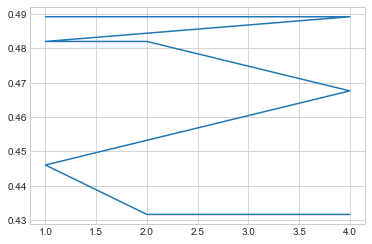

In [33]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','min_samples_leaf','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for leaf in min_samples_leaf:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                min_samples_leaf_parameter=leaf)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 min_samples_leaf_parameter=leaf)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), min_samples_leaf_parameter=leaf)
        result.append(leaf)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['min_samples_leaf'],statistics['mae'])
selected_min_samples_leaf = statistics.sort_values(by=['mae'])['min_samples_leaf'].head(1).values[0]
print("Selected min_samples_leaf: ",selected_min_samples_leaf)

### Run RandomSearchCV for parameter tunning

In [34]:
results = []
pipe = Pipeline([('standardizer', StandardScaler()), ('rf', RandomForestClassifier())])
clf = RandomizedSearchCV(
   pipe, param_distributions = random_grid, n_iter = 100, cv=selected_fold,n_jobs=-1,verbose=1
)
clf.fit(train_X_rolling_mean,train_Y.ravel())
results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results)
display(gridcv_results)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.9min finished


,rf__n_estimators,rf__min_samples_split,rf__min_samples_leaf,rf__max_features,rf__max_depth,rf__criterion,rf__bootstrap
0,200,5,2,log2,60,entropy,True


### Best Parameters
Display the best parameters tunned throughout the experiments

In [35]:
conclusion_cols=['Cross_Validation','Number of Estimators','Max Features','Max Depth','Criterion','Min_Samples_Leaf','Min_Samples_Split','Preprocessing']
conclusion_list = [selected_method,selected_estimator_size,selected_max_feature,selected_max_depth,selected_criterion,
                   selected_min_samples_leaf,selected_min_samples_splith,selected_preprocessing]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,Cross_Validation,Number of Estimators,Max Features,Max Depth,Criterion,Min_Samples_Leaf,Min_Samples_Split,Preprocessing
0,HoldOut,600,auto,10.0,entropy,2,2,StandardScaler


### Best Results
Compute RF with the best parameters tuned by RandomGridSearchCV and manually tuned

In [36]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','run','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
final_Type = ''
for i in range(3):
    if i == 0: #Default Run
        final_Type = 'DEFAULT'
        criterion = 'gini'
        estimators = 100
        depth = None
        max_feat = 'auto'
        min_samples_split = 2
        min_samples_leaf = 1
    if i == 1:#Manually Tuned Run
        final_Type = 'MANUALLY TUNED'
        criterion = selected_criterion
        estimators = selected_estimator_size
        depth = selected_max_depth
        max_feat = selected_max_feature
        min_samples_split = selected_min_samples_splith
        min_samples_leaf = selected_min_samples_leaf
    if i == 2: #Grid Run
        final_Type = 'GRID TUNED'
        criterion = clf.best_params_['rf__criterion']
        estimators = clf.best_params_['rf__n_estimators']
        depth = clf.best_params_['rf__max_depth']
        max_feat = clf.best_params_['rf__max_features']
        min_samples_split = clf.best_params_['rf__min_samples_split']
        min_samples_leaf = clf.best_params_['rf__min_samples_leaf']
    for scannedType in types:
        if scannedType == 'RSSI Only':
            trainX_data = train_X_rssi
        elif scannedType == 'Rolling Mean RSSI':
            trainX_data = train_X_rolling_mean
        else:
            trainX_data = combination_features_X
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                n_estimators_parameter=estimators,criterion_parameter=criterion,
                                              max_depth_parameter=depth, max_features_parameter=max_feat,
                                              min_samples_leaf_parameter=min_samples_leaf,
                                              min_samples_split_parameter=min_samples_split)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                n_estimators_parameter=estimators,criterion_parameter=criterion,
                                              max_depth_parameter=depth, max_features_parameter=max_feat,
                                              min_samples_leaf_parameter=min_samples_leaf,
                                              min_samples_split_parameter=min_samples_split) 
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),n_estimators_parameter=estimators,criterion_parameter=criterion,
                                              max_depth_parameter=depth, max_features_parameter=max_feat,
                                              min_samples_leaf_parameter=min_samples_leaf,
                                              min_samples_split_parameter=min_samples_split) 
        result.append(final_Type)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending = False))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('RF Classification')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../proximity_results.csv',mode='a',index=False,header=False)
dataset = load_file('../proximity_results.csv')
dataset = dataset.sort_values(by=['mae'])
dataset.to_csv('../proximity_results.csv',index=False)

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 1'

'Number of Classes Predicted: 4'

'Number of Features Used: 2'

,mae,mse,rmse,precision,accuracy,f1-score,run,type
5,0.446043,0.446043,0.667865,0.553195,0.553957,0.542591,MANUALLY TUNED,Both
8,0.446043,0.446043,0.667865,0.556899,0.553957,0.540562,GRID TUNED,Both
2,0.446043,0.446043,0.667865,0.544970,0.553957,0.540121,DEFAULT,Both
4,0.467626,0.467626,0.683832,0.552251,0.532374,0.529581,MANUALLY TUNED,Rolling Mean RSSI
7,0.482014,0.482014,0.694273,0.532806,0.517986,0.513623,GRID TUNED,Rolling Mean RSSI
1,0.482014,0.482014,0.694273,0.531706,0.517986,0.513285,DEFAULT,Rolling Mean RSSI
0,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,DEFAULT,RSSI Only
3,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,MANUALLY TUNED,RSSI Only
6,0.489209,0.489209,0.699435,0.514749,0.510791,0.501925,GRID TUNED,RSSI Only


### Best Results - Testing data being 1000 plot points
Experiment with testing data of 1000 plot points

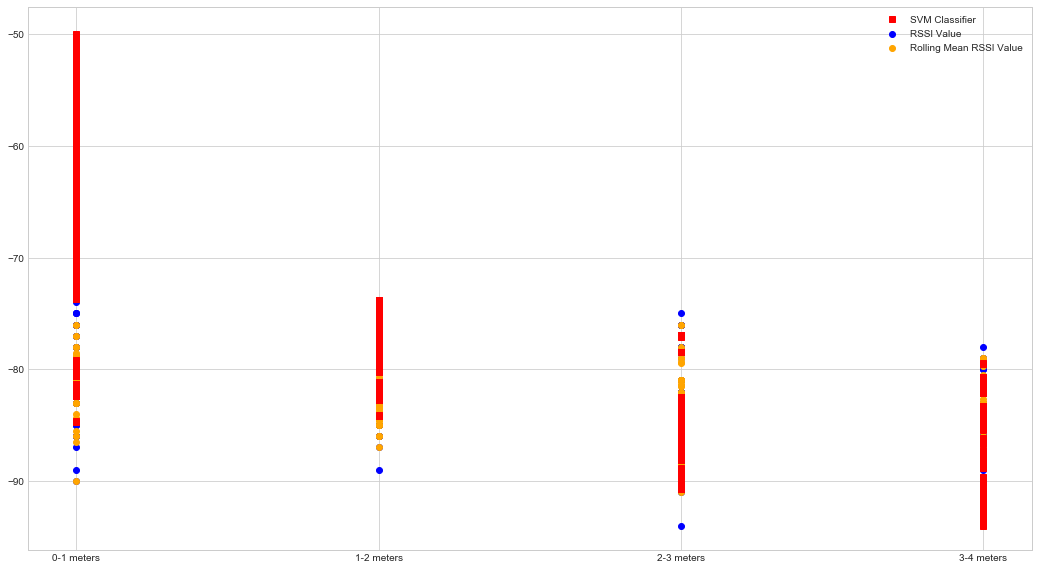

In [42]:
testX_data = np.linspace(dataset['rssi_Value'].min(), dataset['rssi_Value'].max(), 1000).reshape(-1,1)
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
svc_estimator = RandomForestClassifier()
main_estimator = make_pipeline(StandardScaler(),svc_estimator)
main_estimator.fit(train_X_rolling_mean,train_Y.ravel())
predict_test = main_estimator.predict(testX_data)
plt.show()
plt.figure(figsize=(18,10))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.plot(predict_test, testX_data,'s',color='red', label='SVM Classifier')
# Show and place the legent
plt.legend(loc='upper right')
plt.show()